In [39]:
import os, json, glob
from pathlib import Path
import pandas as pd


# Where your BBL JSON files are
DATA_DIR = Path("Downloads/bbl_json")

# Where to save the cleaned CSV files
OUTPUT_DIR = Path("Downloads/bbl_cleaned")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MATCHES_OUT = OUTPUT_DIR / "cleaned_match_data.csv"
BALLS_OUT   = OUTPUT_DIR / "cleaned_ball_by_ball_data.csv"

# Recursively find JSON files
json_files = sorted(glob.glob(str(DATA_DIR / "**" / "*.json"), recursive=True))
print(f"Found {len(json_files)} JSON files")

def load_json_safe(fp):
    """Load a JSON file with defensive handling."""
    try:
        with open(fp, "r", encoding="utf-8") as f:
            return json.load(f)
    except UnicodeDecodeError:
        with open(fp, "r", encoding="latin-1") as f:
            return json.load(f)
    except json.JSONDecodeError as e:
        print(f"[SKIP] Bad JSON: {fp} ({e})")
        return None

raw_matches = []
valid_file_paths = []  # keep only those that loaded successfully

for fp in json_files:
    obj = load_json_safe(fp)
    if obj is not None:
        raw_matches.append(obj)
        valid_file_paths.append(fp)

print(f"Loaded {len(raw_matches)} JSON objects")

# Safety: make sure lengths line up
assert len(raw_matches) == len(valid_file_paths), "Mismatch between files and JSON objects"


def clean_venues(venue: str) -> str:
    """
    Standardise venue names so the same ground is always represented
    with one consistent string.
    Extend this mapping if you find more variants.
    """
    mapping = {
        'Aurora Stadium': 'Aurora Stadium, Launceston',
        'Brisbane Cricket Ground': 'Brisbane Cricket Ground, Woolloongabba, Brisbane',
        'Brisbane Cricket Ground, Woolloongabba': 'Brisbane Cricket Ground, Woolloongabba, Brisbane',
        'Bellerive Oval': 'Bellerive Oval, Hobart',
        'Docklands Stadium': 'Docklands Stadium, Melbourne',
        'Geelong Cricket Ground': 'GMHBA Stadium, South Geelong, Victoria',
        'Simonds Stadium, South Geelong, Victoria': 'GMHBA Stadium, South Geelong, Victoria',
        'International Sports Stadium': 'International Sports Stadium, Coffs Harbour',
        'Manuka Oval': 'Manuka Oval, Canberra',
        'W.A.C.A. Ground': 'Western Australia Cricket Association Ground',
        'Sydney Cricket Ground': 'Sydney Cricket Ground, Sydney',
        # Add extra aliases here if you find them
        # 'Blundstone Arena': 'Bellerive Oval, Hobart',
    }

    return mapping.get(venue, venue)


def get_home_team(info: dict) -> str | None:
    """
    Infer the home team from venue + team list.
    Returns None for neutral / hub matches or unmapped venues.
    """
    venue = clean_venues(info['venue'])
    teams = info['teams']

    if venue == 'Adelaide Oval' and 'Adelaide Strikers' in teams:
        return 'Adelaide Strikers'
    elif venue == 'Aurora Stadium, Launceston' and 'Hobart Hurricanes' in teams:
        return 'Hobart Hurricanes'
    elif venue == 'Bellerive Oval, Hobart' and 'Hobart Hurricanes' in teams:
        return 'Hobart Hurricanes'
    elif venue == 'Brisbane Cricket Ground, Woolloongabba, Brisbane' and 'Brisbane Heat' in teams:
        return 'Brisbane Heat'
    elif venue == 'Docklands Stadium, Melbourne' and 'Melbourne Renegades' in teams:
        return 'Melbourne Renegades'
    elif venue == 'Carrara Oval' and 'Brisbane Heat' in teams:
        return 'Brisbane Heat'
    elif venue == 'GMHBA Stadium, South Geelong, Victoria' and 'Melbourne Renegades' in teams:
        return 'Melbourne Renegades'
    elif venue == 'Melbourne Cricket Ground' and 'Melbourne Stars' in teams:
        return 'Melbourne Stars'
    elif venue == 'Melbourne Cricket Ground' and 'Melbourne Renegades' in teams:
        return 'Melbourne Renegades'
    elif venue == 'Perth Stadium' and 'Perth Scorchers' in teams:
        return 'Perth Scorchers'
    elif venue == 'Stadium Australia' and 'Sydney Sixers' in teams:
        return 'Sydney Sixers'
    elif venue == 'Stadium Australia' and 'Sydney Thunder' in teams:
        return 'Sydney Thunder'
    elif venue == 'Sydney Cricket Ground, Sydney' and 'Sydney Sixers' in teams:
        return 'Sydney Sixers'
    elif venue == 'Sydney Cricket Ground, Sydney' and 'Sydney Thunder' in teams:
        return 'Sydney Thunder'
    elif venue == 'Sydney Showground Stadium' and 'Sydney Thunder' in teams:
        return 'Sydney Thunder'
    elif venue == 'Sydney Showground Stadium' and 'Sydney Sixers' in teams:
        return 'Sydney Sixers'
    elif venue == 'Manuka Oval, Canberra' and 'Sydney Thunder' in teams:
        return 'Sydney Thunder'
    elif venue == 'Manuka Oval, Canberra' and 'Sydney Sixers' in teams:
        return 'Sydney Sixers'
    elif venue == 'Western Australia Cricket Association Ground' and 'Perth Scorchers' in teams:
        return 'Perth Scorchers'
    elif venue == 'University of Tasmania Stadium, Launceston' and 'Hobart Hurricanes' in teams:
        return 'Hobart Hurricanes'
    else:
        return None


def build_matches_df(objs, file_paths) -> pd.DataFrame:
    rows = []

    for obj, fp in zip(objs, file_paths):
        info = obj.get("info", {})
        if not info:
            continue

        # Clean venue
        info['venue'] = clean_venues(info.get('venue'))

        # Outcome may be missing or partial
        outcome = info.get('outcome', {})
        if not isinstance(outcome, dict):
            outcome = {}
        by = outcome.get('by', {})
        if not isinstance(by, dict):
            by = {}

        # match_id from file name
        match_id = Path(fp).stem

        row = {
            "match_id": match_id,
            "date": info.get("dates", [None])[0],
            "team1": info.get("teams", [None, None])[0],
            "team2": info.get("teams", [None, None])[1],
            "winner": outcome.get('winner', None),
            "result": outcome.get('result', None),
            "winner_by_runs": by.get('runs', None),
            "winner_by_wickets": by.get('wickets', None),
            "venue": info.get('venue'),
            "toss_winner": info.get('toss', {}).get('winner', None),
            "toss_decision": info.get('toss', {}).get('decision', None),
            "home_team": get_home_team(info),
        }

        rows.append(row)

    matches_df = pd.DataFrame(rows)

    # --- Cleaning ---
    matches_df["date"] = pd.to_datetime(matches_df["date"], errors="coerce")

    matches_df = matches_df.sort_values("date").reset_index(drop=True)

    return matches_df
# Check some entries
venue_counts = matches_df['venue'].value_counts()
venue_counts
home_team_counts = matches_df['home_team'].value_counts()
home_team_counts

col_names = ['team1', 'team2', 'venue', 'home_team']
matches_df[matches_df['home_team'].isna()][col_names]


balls_template = pd.DataFrame(
    columns=[
        'match_id', 'date', 'team1', 'team2', 'home_team', 'winner',
        'result', 'winner_by_runs', 'winner_by_wickets',
        'innings', 'team', 'over', 'delivery', 'batter',
        'bowler', 'runs_batter', 'runs_total', 'wicket',
        'wicket_type', 'wicket_player_out', 'powerplay',
        'powerplay_type', 'venue'
    ]
)

matches_balls = []

for i, (obj, fp) in enumerate(zip(raw_matches, valid_file_paths), start=1):
    print(f"Processing file {i} of {len(raw_matches)}: {Path(fp).name}")

    info = obj.get("info", {})
    innings_list = obj.get("innings", [])
    if not info or not innings_list:
        continue

    info['venue'] = clean_venues(info.get('venue'))

    outcome = info.get('outcome', {})
    if not isinstance(outcome, dict):
        outcome = {}
    by = outcome.get('by', {})
    if not isinstance(by, dict):
        by = {}

    match_id = Path(fp).stem

    row_meta = {
        'match_id': match_id,
        'date': info.get('dates', [None])[0],
        'team1': info.get('teams', [None, None])[0],
        'team2': info.get('teams', [None, None])[1],
        'home_team': get_home_team(info),
        'winner': outcome.get('winner', None),
        'result': outcome.get('result', None),
        'winner_by_runs': by.get('runs', None),
        'winner_by_wickets': by.get('wickets', None),
        'venue': info.get('venue')
    }

    match_balls = balls_template.copy()

    innings_count = 0
    for innings in innings_list:
        innings_count += 1
        team_innings = innings.get('team')

        overs = innings.get('overs', [])
        pps = innings.get('powerplays', [])

        over_count = 0
        for over in overs:
            over_count += 1
            deliveries = over.get('deliveries', [])

            delivery_count = 0
            for delivery in deliveries:
                delivery_count += 1
                row = row_meta.copy()
                row['innings'] = innings_count
                row['team'] = team_innings
                row['over'] = over_count
                row['delivery'] = delivery_count
                row['batter'] = delivery.get('batter')
                row['bowler'] = delivery.get('bowler')
                row['runs_batter'] = delivery.get('runs', {}).get('batter', 0)
                row['runs_total'] = delivery.get('runs', {}).get('total', 0)

                # Wickets
                if 'wickets' in delivery and delivery['wickets']:
                    row['wicket_type'] = delivery['wickets'][0].get('kind')
                    row['wicket_player_out'] = delivery['wickets'][0].get('player_out')
                    row['wicket'] = True
                else:
                    row['wicket_type'] = None
                    row['wicket_player_out'] = None
                    row['wicket'] = False

                # Powerplays
                if pps:
                    for powerplay in pps:
                        if powerplay.get('from') <= over_count <= powerplay.get('to'):
                            row['powerplay'] = True
                            row['powerplay_type'] = powerplay.get('type')
                            break
                    else:
                        row['powerplay'] = False
                        row['powerplay_type'] = None
                else:
                    row['powerplay'] = False
                    row['powerplay_type'] = None

                match_balls.loc[len(match_balls)] = row

    matches_balls.append(match_balls)

balls = pd.concat(matches_balls, ignore_index=True)

# CLEAN TYPES
balls['date'] = pd.to_datetime(balls['date'], errors='coerce')

for col in ['wicket', 'powerplay']:
    balls[col] = balls[col].astype(bool)

int_cols = ['innings', 'over', 'delivery', 'runs_batter', 'runs_total']
for col in int_cols:
    balls[col] = pd.to_numeric(balls[col], errors='coerce').astype('Int64')

balls = balls.sort_values(by=['date', 'match_id', 'innings', 'over', 'delivery']).reset_index(drop=True)

print("Balls shape:", balls.shape)


matches_df = build_matches_df(raw_matches, valid_file_paths)
balls_df = balls   # <-- Use the manually built ball-by-ball dataframe


print("Matches shape:", matches_df.shape)
print("Balls shape:", balls_df.shape)

# Quick sanity checks
print("\n[CHECK] Venues (top 20):")
print(matches_df["venue"].value_counts().head(20))

print("\n[CHECK] Rows with missing home_team (first 10):")
print(
    matches_df[matches_df["home_team"].isna()][
        ["match_id", "date", "team1", "team2", "venue"]
    ].head(10)
)

# Save to CSV
matches_df.to_csv(MATCHES_OUT, index=False)
balls_df.to_csv(BALLS_OUT, index=False)

print(f"\nSaved matches to: {MATCHES_OUT}")
print(f"Saved balls to:   {BALLS_OUT}")


Found 618 JSON files
[SKIP] Bad JSON: Downloads/bbl_json/1386114.json (Extra data: line 1 column 5 (char 4))
Loaded 617 JSON objects


NameError: name 'matches_df' is not defined

In [5]:
#All matches by each season
import pandas as pd

# Load cleaned matches
matches = pd.read_csv("Downloads/bbl_cleaned/cleaned_match_data.csv")

# Parse date
matches["date"] = pd.to_datetime(matches["date"], errors="coerce")

# Helper: map each match to a BBL season like "2011/12"
def get_bbl_season(dt):
    if pd.isna(dt):
        return None
    year = dt.year
    # BBL season runs over summer; if month >= Sep, season starts this year
    if dt.month >= 9:
        start = year
    else:
        start = year - 1
    end_short = str(start + 1)[-2:]
    return f"{start}/{end_short}"

matches["season"] = matches["date"].apply(get_bbl_season)

matches[["match_id", "date", "season"]].head()
# Get the 8 BBL teams
teams = sorted(set(matches["team1"]).union(set(matches["team2"])))

season_stats = []

for team in teams:
    df_team = matches[
        (matches["team1"] == team) | (matches["team2"] == team)
    ].copy()

    # Group by season
    grouped = df_team.groupby("season", dropna=True)

    for season, g in grouped:
        total_matches = len(g)
        wins = (g["winner"] == team).sum()
        win_ratio = wins / total_matches if total_matches > 0 else 0

        season_stats.append(
            {
                "team": team,
                "season": season,
                "matches_played": total_matches,
                "wins": wins,
                "win_ratio": win_ratio,
            }
        )

season_stats_df = pd.DataFrame(season_stats)
season_stats_df.head()
season_stats_df = season_stats_df.sort_values(
    by=["team", "season"]
).reset_index(drop=True)

season_stats_df.head(20)


,team,season,matches_played,wins,win_ratio
0,Adelaide Strikers,2011/12,6,1,0.166667
1,Adelaide Strikers,2012/13,7,3,0.428571
2,Adelaide Strikers,2013/14,7,1,0.142857
3,Adelaide Strikers,2014/15,9,6,0.666667
4,Adelaide Strikers,2015/16,9,7,0.777778
5,Adelaide Strikers,2016/17,8,3,0.375000
6,Adelaide Strikers,2017/18,12,9,0.750000
7,Adelaide Strikers,2018/19,14,6,0.428571
8,Adelaide Strikers,2019/20,15,8,0.533333
9,Adelaide Strikers,2020/21,15,7,0.466667


In [7]:
#All matches except neutral venues
import pandas as pd

# Load your cleaned match data
matches = pd.read_csv("Downloads/bbl_cleaned/cleaned_match_data.csv")

# Convert date
matches['date'] = pd.to_datetime(matches['date'], errors='coerce')

# Remove neutral venues (where home_team is NaN)
matches_no_neutral = matches.dropna(subset=['home_team']).copy()

teams = sorted(set(matches['team1']).union(set(matches['team2'])))
teams
team_stats = []

for team in teams:
    df = matches_no_neutral[
        (matches_no_neutral['team1'] == team) | 
        (matches_no_neutral['team2'] == team)
    ]

    total_matches = len(df)
    wins = (df['winner'] == team).sum()
    win_ratio = wins / total_matches if total_matches > 0 else 0

    team_stats.append({
        'team': team,
        'matches_played': total_matches,
        'wins': wins,
        'win_ratio': round(win_ratio, 3)
    })

team_stats_df = pd.DataFrame(team_stats)
team_stats_df


,team,matches_played,wins,win_ratio
0,Adelaide Strikers,144,70,0.486
1,Brisbane Heat,144,65,0.451
2,Hobart Hurricanes,140,70,0.500
3,Melbourne Renegades,142,58,0.408
4,Melbourne Stars,144,69,0.479
5,Perth Scorchers,146,86,0.589
6,Sydney Sixers,146,88,0.603
7,Sydney Thunder,140,55,0.393


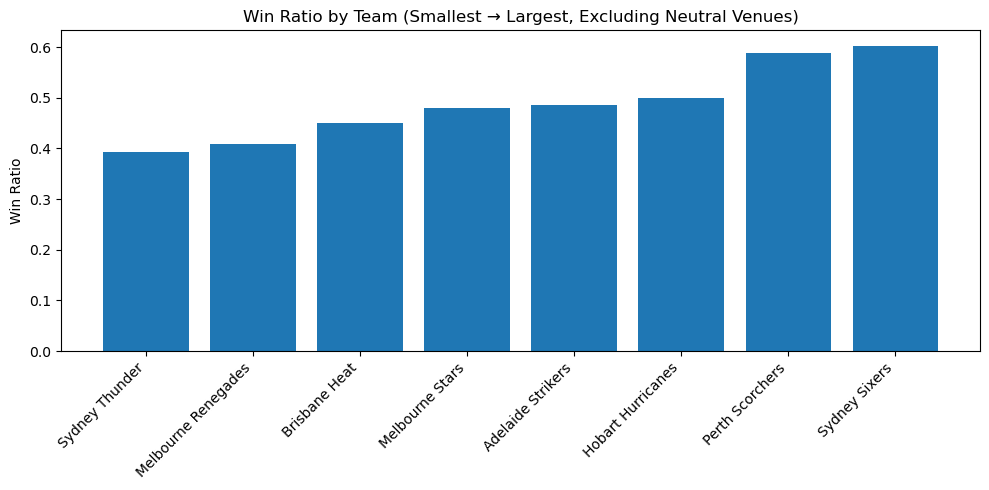

In [165]:
# Sort the dataframe by win_ratio
sorted_df = team_stats_df.sort_values('win_ratio')

plt.figure(figsize=(10,5))
plt.bar(sorted_df['team'], sorted_df['win_ratio'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Win Ratio")
plt.title("Win Ratio by Team (Smallest → Largest, Excluding Neutral Venues)")
plt.tight_layout()
plt.show()


In [9]:
#Home-ground winning ratio for each team
import pandas as pd

matches = pd.read_csv("Downloads/bbl_cleaned/cleaned_match_data.csv")
matches['date'] = pd.to_datetime(matches['date'], errors='coerce')

# Keep only matches where the home team is known (remove neutral/hub venues)
home_matches = matches.dropna(subset=['home_team']).copy()
teams = sorted(set(matches['team1']).union(set(matches['team2'])))

home_stats = []

for team in teams:
    # All matches where this team was the home side
    df_home = home_matches[home_matches['home_team'] == team]

    total_home = len(df_home)
    home_wins = (df_home['winner'] == team).sum()

    win_ratio = home_wins / total_home if total_home > 0 else 0

    home_stats.append({
        'team': team,
        'home_matches': total_home,
        'home_wins': home_wins,
        'home_win_ratio': round(win_ratio, 3)
    })

home_stats_df = pd.DataFrame(home_stats)
home_stats_df


,team,home_matches,home_wins,home_win_ratio
0,Adelaide Strikers,76,42,0.553
1,Brisbane Heat,72,30,0.417
2,Hobart Hurricanes,71,40,0.563
3,Melbourne Renegades,76,31,0.408
4,Melbourne Stars,65,34,0.523
5,Perth Scorchers,75,51,0.680
6,Sydney Sixers,72,46,0.639
7,Sydney Thunder,66,29,0.439


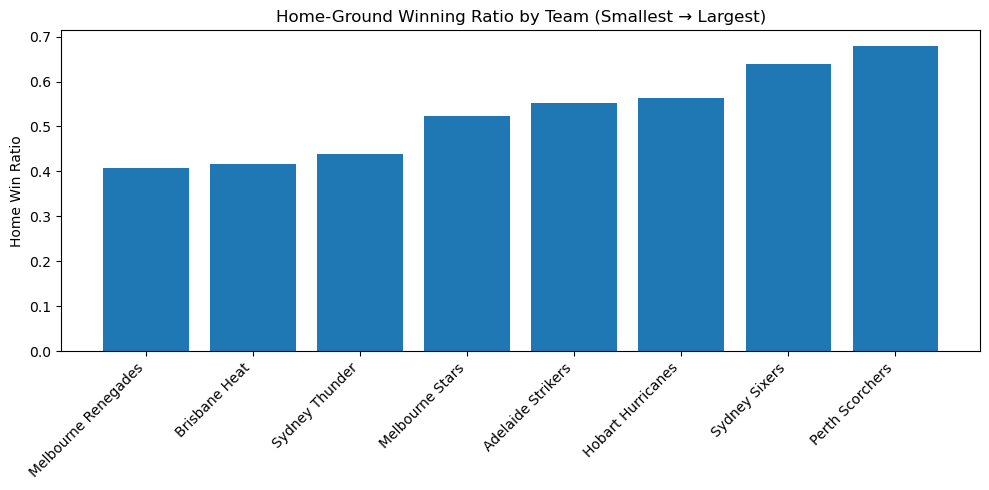

In [11]:
import matplotlib.pyplot as plt

sorted_home = home_stats_df.sort_values("home_win_ratio")

plt.figure(figsize=(10,5))
plt.bar(sorted_home['team'], sorted_home['home_win_ratio'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Home Win Ratio")
plt.title("Home-Ground Winning Ratio by Team (Smallest → Largest)")
plt.tight_layout()
plt.show()


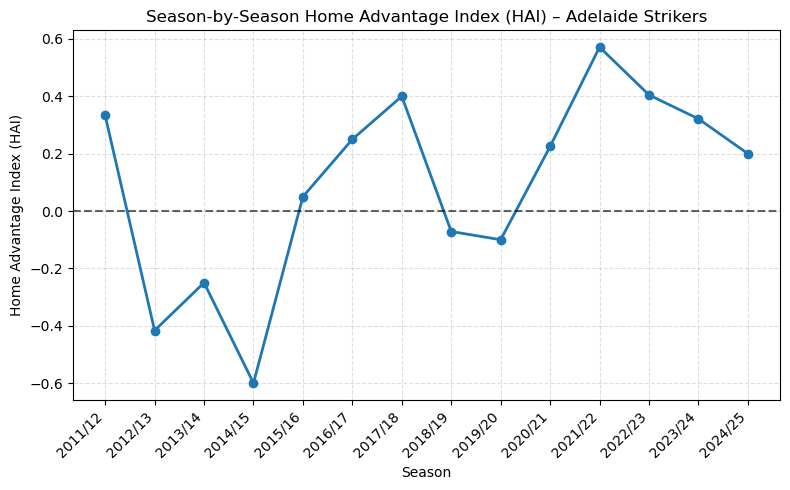

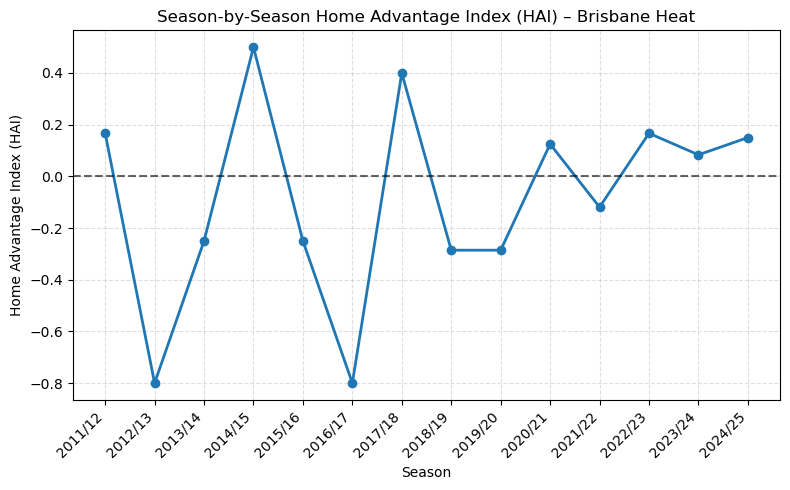

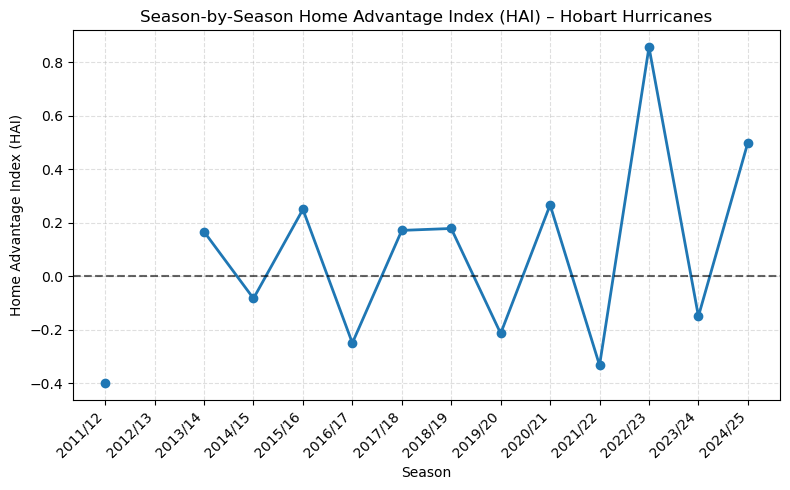

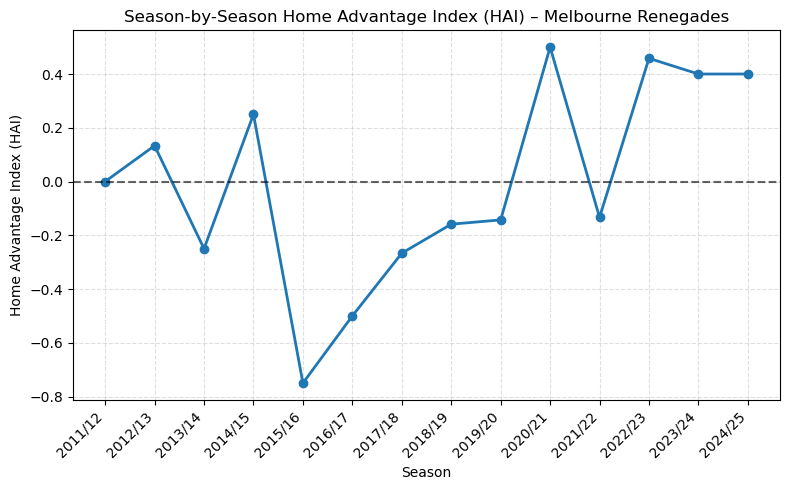

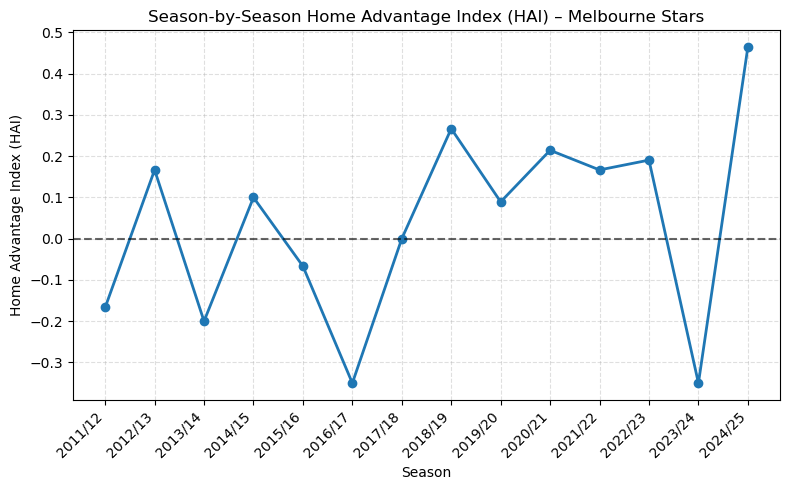

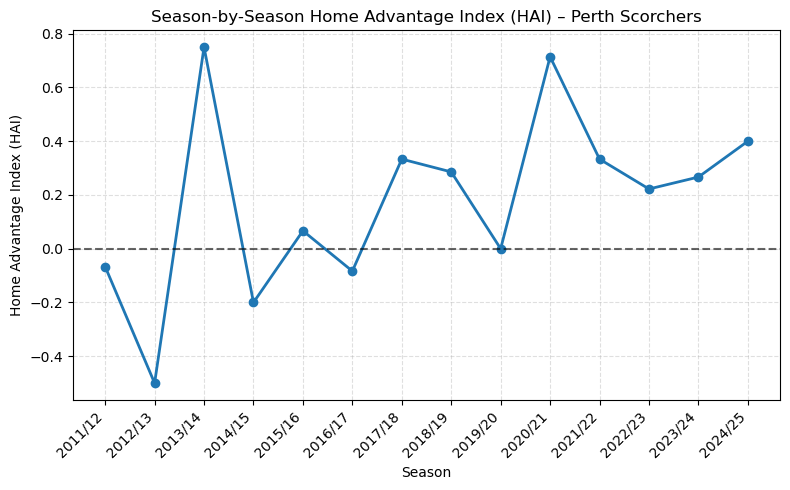

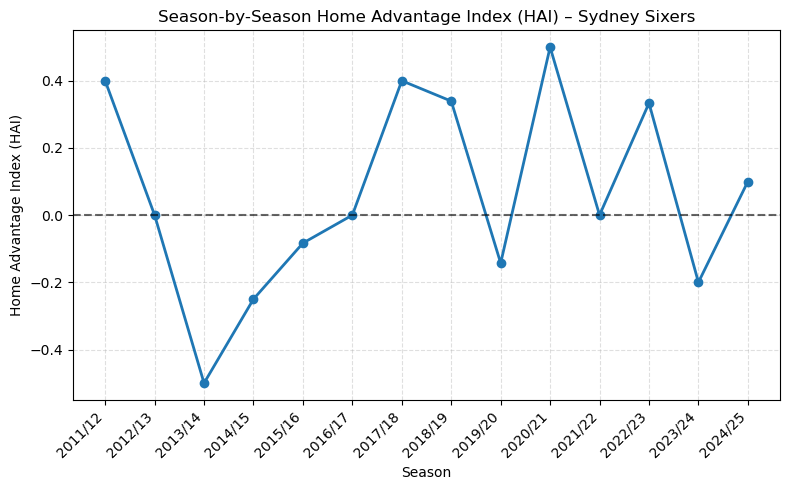

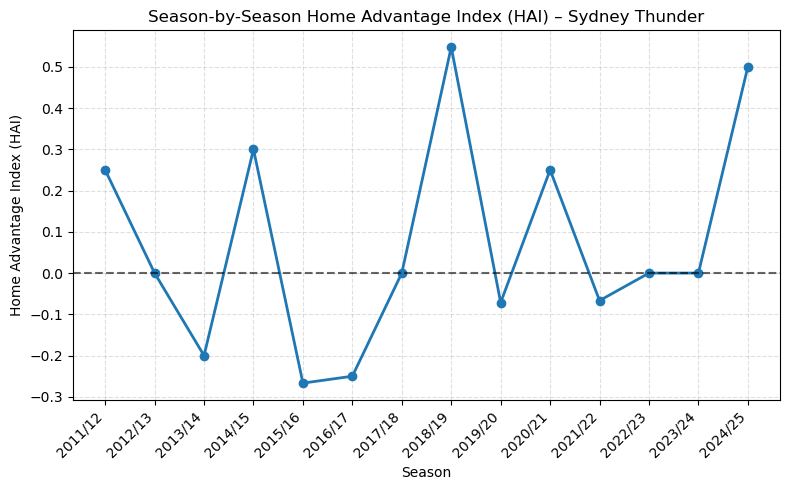

In [13]:
#Home Advantage Index
import pandas as pd

matches = pd.read_csv("Downloads/bbl_cleaned/cleaned_match_data.csv")
matches['date'] = pd.to_datetime(matches['date'], errors='coerce')
def get_bbl_season(dt):
    if pd.isna(dt):
        return None
    year = dt.year
    if dt.month >= 9:
        start = year
    else:
        start = year - 1
    end_short = str(start + 1)[-2:]
    return f"{start}/{end_short}"

matches['season'] = matches['date'].apply(get_bbl_season)

teams = sorted(set(matches['team1']).union(set(matches['team2'])))

hai_rows = []

for team in teams:
    team_matches = matches[
        (matches['team1'] == team) | (matches['team2'] == team)
    ].copy()

    # Identify home vs away
    team_matches['is_home'] = team_matches['home_team'] == team
    team_matches['is_away'] = team_matches['home_team'].notna() & (team_matches['home_team'] != team)
    
    # Group by season
    grouped = team_matches.groupby('season', dropna=True)

    for season, g in grouped:
        # Home stats
        home_games = g[g['is_home']]
        home_wins = (home_games['winner'] == team).sum()
        home_total = len(home_games)
        home_ratio = home_wins / home_total if home_total > 0 else None

        # Away stats
        away_games = g[g['is_away']]
        away_wins = (away_games['winner'] == team).sum()
        away_total = len(away_games)
        away_ratio = away_wins / away_total if away_total > 0 else None

        # HAI (only if both ratios exist)
        if home_ratio is not None and away_ratio is not None:
            hai = home_ratio - away_ratio
        else:
            hai = None

        hai_rows.append({
            'team': team,
            'season': season,
            'home_win_ratio': home_ratio,
            'away_win_ratio': away_ratio,
            'HAI': hai,
            'home_games': home_total,
            'away_games': away_total
        })

hai_df = pd.DataFrame(hai_rows)

hai_df['season_start'] = hai_df['season'].apply(lambda x: int(x.split('/')[0]))
hai_df = hai_df.sort_values(['team', 'season_start'])
import matplotlib.pyplot as plt

for team in teams:
    df_t = hai_df[hai_df['team'] == team]

    plt.figure(figsize=(8,5))
    plt.plot(df_t['season'], df_t['HAI'], marker='o', linewidth=2)

    plt.axhline(0, color='black', linestyle='--', alpha=0.6)  # baseline: no advantage

    plt.title(f"Season-by-Season Home Advantage Index (HAI) – {team}")
    plt.ylabel("Home Advantage Index (HAI)")
    plt.xlabel("Season")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [15]:
import pandas as pd

# Load match & HAI data
matches = pd.read_csv("Downloads/bbl_cleaned/cleaned_match_data.csv")
matches['date'] = pd.to_datetime(matches['date'], errors='coerce')

hai_df = hai_df.copy()   # use the HAI table you created earlier

# Function to get BBL season
def get_bbl_season(dt):
    year = dt.year
    if dt.month >= 9:
        start = year
    else:
        start = year - 1
    return f"{start}/{str(start+1)[-2:]}"

matches['season'] = matches['date'].apply(get_bbl_season)



def diagnose_missing_HAI(team_name):
    print(f"\n===============================")
    print(f"   DIAGNOSTIC REPORT FOR: {team_name}")
    print(f"===============================\n")

    team_hai = hai_df[hai_df['team'] == team_name]

    # Find seasons where HAI is NaN
    missing = team_hai[team_hai['HAI'].isna()]

    if missing.empty:
        print("No missing HAI values — all seasons have valid home/away data.")
        return

    print("Missing HAI detected in seasons:\n")
    print(missing[['season', 'home_games', 'away_games']].to_string(index=False))
    print("\n---------------------------------------------")
    print("Checking reasons for missing HAI...\n")

    for _, row in missing.iterrows():
        season = row['season']
        home = row['home_games']
        away = row['away_games']

        print(f"🔸 SEASON {season}")

        # Case 1: No home games
        if home == 0 and away > 0:
            print("   ❗ No home games played → cannot compute home win ratio.")
            continue
        
        # Case 2: No away games
        if away == 0 and home > 0:
            print("   ❗ No away games played → cannot compute away win ratio.")
            continue

        # Case 3: Neither home nor away (all neutral)
        if home == 0 and away == 0:
            print("   ❗ All matches were at NEUTRAL venues → no home/away data.")
            continue

        # Rare fallback case
        print("   ❗ Missing for an unusual reason — inspect match logs.")

        # Print the raw matches for this season for inspection
        season_matches = matches[
            ((matches['team1'] == team_name) | (matches['team2'] == team_name)) &
            (matches['season'] == season)
        ][['match_id','season','home_team','winner','venue']]

        print("\nAffected matches:")
        print(season_matches.to_string(index=False))
        print()

# Run for Hobart Hurricanes
diagnose_missing_HAI("Hobart Hurricanes")

# Run for all teams (optional)
# for t in sorted(set(matches['team1']).union(set(matches['team2']))):
#     diagnose_missing_HAI(t)



   DIAGNOSTIC REPORT FOR: Hobart Hurricanes

Missing HAI detected in seasons:

 season  home_games  away_games
2012/13           0           4

---------------------------------------------
Checking reasons for missing HAI...

🔸 SEASON 2012/13
   ❗ No home games played → cannot compute home win ratio.


In [17]:
#Cleaning data of draws/tie etc first then computing winning probability

import pandas as pd

matches = pd.read_csv("Downloads/bbl_cleaned/cleaned_match_data.csv")
matches['date'] = pd.to_datetime(matches['date'], errors='coerce')
# Remove no-result, abandoned, rained out, ties, bowl-offs
invalid_results = ['no result', 'tie', 'bowl off', 'bowl-off', 'abandoned']

clean_matches = matches[
    (~matches['result'].isin(invalid_results)) &   # remove invalid result types
    (matches['winner'].notna())                   # must have an actual winner
].copy()

clean_matches.shape
clean_home_matches = clean_matches.dropna(subset=['home_team']).copy()
clean_home_matches.shape
teams = sorted(set(clean_matches['team1']).union(set(clean_matches['team2'])))

home_prob_rows = []

for team in teams:
    
    team_home = clean_home_matches[
        clean_home_matches['home_team'] == team
    ]
    
    home_games = len(team_home)
    home_wins = (team_home['winner'] == team).sum()
    
    home_win_prob = home_wins / home_games if home_games > 0 else None
    
    home_prob_rows.append({
        'team': team,
        'home_games': home_games,
        'home_wins': home_wins,
        'home_win_probability': round(home_win_prob, 3) if home_win_prob is not None else None
    })

home_prob_df = pd.DataFrame(home_prob_rows)
home_prob_df

,team,home_games,home_wins,home_win_probability
0,Adelaide Strikers,75,42,0.560
1,Brisbane Heat,70,30,0.429
2,Hobart Hurricanes,70,40,0.571
3,Melbourne Renegades,75,31,0.413
4,Melbourne Stars,64,34,0.531
5,Perth Scorchers,75,51,0.680
6,Sydney Sixers,68,46,0.676
7,Sydney Thunder,64,29,0.453


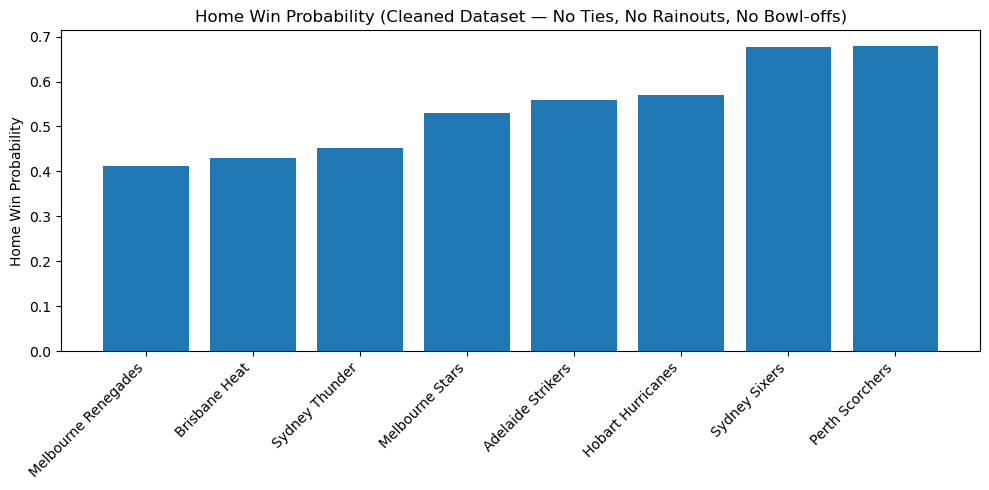

In [19]:
import matplotlib.pyplot as plt

plot_df = home_prob_df.dropna(subset=['home_win_probability'])
plot_df = plot_df.sort_values('home_win_probability')

plt.figure(figsize=(10,5))
plt.bar(plot_df['team'], plot_df['home_win_probability'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Home Win Probability")
plt.title("Home Win Probability (Cleaned Dataset — No Ties, No Rainouts, No Bowl-offs)")
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd

matches = pd.read_csv("Downloads/bbl_cleaned/cleaned_match_data.csv")
matches['date'] = pd.to_datetime(matches['date'], errors='coerce')

# Remove invalid games
invalid_results = ['no result', 'tie', 'bowl off', 'bowl-off', 'abandoned']
df = matches[
    (~matches['result'].isin(invalid_results)) &
    (matches['winner'].notna()) &
    (matches['home_team'].notna())
].copy()

# Convert to long format: one row per team per match
rows = []

for _, row in df.iterrows():
    # Home team row
    rows.append({
        "team": row["home_team"],
        "is_home": 1,
        "win": int(row["winner"] == row["home_team"])
    })
    # Away team row
    away_team = row["team2"] if row["home_team"] == row["team1"] else row["team1"]
    rows.append({
        "team": away_team,
        "is_home": 0,
        "win": int(row["winner"] == away_team)
    })

model_df = pd.DataFrame(rows)
import statsmodels.api as sm

model = sm.BinomialBayesMixedGLM.from_formula(
    "win ~ is_home",                  # fixed effects
    {"team_re": "0 + C(team)"},       # random intercept for each team
    model_df
)

result = model.fit_vb()
print(result.summary())


               Binomial Mixed GLM Results
          Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------
Intercept    M    -0.1615   0.0602                      
is_home      M     0.3262   0.0851                      
team_re      V    -1.1512   0.2608 0.316   0.188   0.533
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard
deviations


In [29]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Simple logistic regression: no random effects
simple_model = smf.logit("win ~ is_home", data=model_df).fit()

print(simple_model.summary())
import numpy as np
beta0 = simple_model.params['Intercept']
beta1 = simple_model.params['is_home']

def logistic(x): return 1 / (1 + np.exp(-x))

p_away = logistic(beta0)
p_home = logistic(beta0 + beta1)
increase = p_home - p_away

print("Away win probability:", round(p_away,3))
print("Home win probability:", round(p_home,3))
print("Increase due to home:", round(increase,3))



Optimization terminated successfully.
         Current function value: 0.689927
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 1122
Model:                          Logit   Df Residuals:                     1120
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:                0.004646
Time:                        19:01:56   Log-Likelihood:                -774.10
converged:                       True   LL-Null:                       -777.71
Covariance Type:            nonrobust   LLR p-value:                  0.007181
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1608      0.085     -1.898      0.058      -0.327       0.005
is_home        0.3215      0.

In [31]:
import pandas as pd

#More parameters here in our model

# Load cleaned match-level data
matches = pd.read_csv("Downloads/bbl_cleaned/cleaned_match_data.csv")
matches["date"] = pd.to_datetime(matches["date"], errors="coerce")

# Remove ties, no result, bowl-off, abandoned, etc.
invalid_results = ["no result", "tie", "bowl off", "bowl-off", "abandoned"]
clean = matches[
    (~matches["result"].isin(invalid_results)) &
    (matches["winner"].notna()) &
    (matches["home_team"].notna())
].copy()

# Sort by date so "recent form" is meaningful
clean = clean.sort_values("date").reset_index(drop=True)
rows = []

for _, row in clean.iterrows():
    # figure out which is away team
    if row["home_team"] == row["team1"]:
        away = row["team2"]
    else:
        away = row["team1"]
    
    # HOME TEAM ROW
    rows.append({
        "match_id": row["match_id"],
        "date": row["date"],
        "team": row["home_team"],
        "opponent": away,
        "is_home": 1,
        "win": int(row["winner"] == row["home_team"]),
        "toss_winner": row["toss_winner"],
        "toss_decision": row["toss_decision"]
    })
    
    # AWAY TEAM ROW
    rows.append({
        "match_id": row["match_id"],
        "date": row["date"],
        "team": away,
        "opponent": row["home_team"],
        "is_home": 0,
        "win": int(row["winner"] == away),
        "toss_winner": row["toss_winner"],
        "toss_decision": row["toss_decision"]
    })

model_df = pd.DataFrame(rows)
# Did this team win the toss?
model_df["toss_win"] = (model_df["team"] == model_df["toss_winner"]).astype(int)

# Did this team win the toss AND choose to bat?
model_df["toss_bat"] = (
    (model_df["toss_win"] == 1) & (model_df["toss_decision"] == "bat")
).astype(int)
# Sort by team + date so rolling works correctly
model_df = model_df.sort_values(["team", "date", "match_id"]).reset_index(drop=True)

# Make sure model_df is sorted first
model_df = model_df.sort_values(["team", "date", "match_id"]).reset_index(drop=True)

def recent_form(series, window=5):
    # previous `window` matches only (shift excludes current)
    return series.shift().rolling(window=window, min_periods=1).mean()

recent = (
    model_df.groupby("team")["win"]
            .apply(lambda s: recent_form(s, window=5))
            .reset_index(level=0, drop=True)   # <— realign index
)

model_df["recent_form_5"] = recent

# Fill any remaining NaNs (very first match of each team)
model_df["recent_form_5"] = model_df["recent_form_5"].fillna(0.5)  # or 0.0 if you prefer

import statsmodels.api as sm

# Mixed-effects logistic regression with random intercept for team
model_extended = sm.BinomialBayesMixedGLM.from_formula(
    "win ~ is_home + toss_win + toss_bat + recent_form_5",
    {"team_re": "0 + C(team)"},   # random intercept per team
    model_df
)

result_ext = model_extended.fit_vb()
print(result_ext.summary())


                 Binomial Mixed GLM Results
              Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------
Intercept        M    -0.3938   0.0604                      
is_home          M     0.3290   0.0853                      
toss_win         M     0.3005   0.0855                      
toss_bat         M    -0.1892   0.1344                      
recent_form_5    M     0.2391   0.1084                      
team_re          V    -1.2203   0.2621 0.295   0.175   0.499
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard deviations


In [33]:
balls = pd.read_csv("Downloads/bbl_cleaned/cleaned_ball_by_ball_data.csv")
print(balls.columns)

Index(['match_id', 'date', 'team1', 'team2', 'home_team', 'winner', 'result',
       'winner_by_runs', 'winner_by_wickets', 'innings', 'team', 'over',
       'delivery', 'batter', 'bowler', 'runs_batter', 'runs_total', 'wicket',
       'wicket_type', 'wicket_player_out', 'powerplay', 'powerplay_type',
       'venue'],
      dtype='object')


In [11]:
balls = pd.read_csv("Downloads/bbl_cleaned/cleaned_ball_by_ball_data.csv")
print(balls.columns)

Index(['match_id', 'date', 'team1', 'team2', 'home_team', 'winner', 'result',
       'winner_by_runs', 'winner_by_wickets', 'venue', 'innings', 'team',
       'over', 'delivery', 'batter', 'bowler', 'runs_batter', 'runs_total',
       'wicket', 'wicket_type', 'wicket_player_out', 'powerplay',
       'powerplay_type'],
      dtype='object')


In [11]:
balls = pd.read_csv("Downloads/bbl_cleaned/cleaned_ball_by_ball_data.csv")
print(balls.columns)

Index(['match_id', 'date', 'team1', 'team2', 'home_team', 'winner', 'result',
       'winner_by_runs', 'winner_by_wickets', 'venue', 'innings', 'team',
       'over', 'delivery', 'batter', 'bowler', 'runs_batter', 'runs_total',
       'wicket', 'wicket_type', 'wicket_player_out', 'powerplay',
       'powerplay_type'],
      dtype='object')


In [35]:
import statsmodels.formula.api as smf

simple_model_ext = smf.logit(
    "win ~ is_home + toss_win + toss_bat + recent_form_5",
    data=model_df
).fit()

print(simple_model_ext.summary())


Optimization terminated successfully.
         Current function value: 0.685945
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 1122
Model:                          Logit   Df Residuals:                     1117
Method:                           MLE   Df Model:                            4
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:                 0.01039
Time:                        19:02:08   Log-Likelihood:                -769.63
converged:                       True   LL-Null:                       -777.71
Covariance Type:            nonrobust   LLR p-value:                  0.002809
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.5333      0.164     -3.258      0.001      -0.854      -0.213
is_home           0.

In [41]:
#player familarity
balls = pd.read_csv("Downloads/bbl_cleaned/cleaned_ball_by_ball_data.csv")

import pandas as pd
import numpy as np


# Batting Statistics


# Per player per venue
bat_stats = (
    balls.groupby(["batter", "venue"], as_index=False)
    .agg(
        runs=("runs_batter", "sum"),
        balls_faced=("delivery", "count")
    )
)

bat_stats["sr_venue"] = 100 * bat_stats["runs"] / bat_stats["balls_faced"]

# Dismissals per player per venue
dismissals = (
    balls[balls["wicket"] == True]
    .groupby(["batter", "venue"], as_index=False)
    .agg(outs=("wicket", "count"))
)

bat_stats = bat_stats.merge(dismissals, on=["batter", "venue"], how="left")
bat_stats["outs"] = bat_stats["outs"].fillna(0)

bat_stats["avg_venue"] = bat_stats["runs"] / bat_stats["outs"].replace(0, np.nan)
bat_overall = (
    balls.groupby("batter", as_index=False)
    .agg(
        runs_total=("runs_batter", "sum"),
        balls_total=("delivery", "count")
    )
)

dismissals_overall = (
    balls[balls["wicket"] == True]
    .groupby("batter", as_index=False)
    .agg(outs_total=("wicket", "count"))
)

bat_overall = bat_overall.merge(dismissals_overall, on="batter", how="left")
bat_overall["outs_total"] = bat_overall["outs_total"].fillna(0)

bat_overall["sr_overall"] = 100 * bat_overall["runs_total"] / bat_overall["balls_total"]
bat_overall["avg_overall"] = bat_overall["runs_total"] / bat_overall["outs_total"].replace(0, np.nan)
bat_merged = bat_stats.merge(bat_overall, on="batter", how="left")

bat_merged["runs_else"]  = bat_merged["runs_total"]  - bat_merged["runs"]
bat_merged["balls_else"] = bat_merged["balls_total"] - bat_merged["balls_faced"]
bat_merged["outs_else"]  = bat_merged["outs_total"]  - bat_merged["outs"]

bat_merged["sr_else"] = np.where(
    bat_merged["balls_else"] > 0,
    100 * bat_merged["runs_else"] / bat_merged["balls_else"],
    np.nan
)

bat_merged["avg_else"] = np.where(
    bat_merged["outs_else"] > 0,
    bat_merged["runs_else"] / bat_merged["outs_else"],
    np.nan
)
# strike rate familiarity
bat_merged["bat_sr_fam"] = bat_merged["sr_venue"] - bat_merged["sr_else"]

# average familiarity
bat_merged["bat_avg_fam"] = bat_merged["avg_venue"] - bat_merged["avg_else"]

bat_merged[["bat_sr_fam", "bat_avg_fam"]] = bat_merged[[
    "bat_sr_fam", "bat_avg_fam"
]].fillna(0.0)



# Bowling Statistics


# Per bowler per venue
bowl_stats = (
    balls.groupby(["bowler", "venue"], as_index=False)
    .agg(
        runs_conceded=("runs_total", "sum"),
        balls_bowled=("delivery", "count")
    )
)

bowl_stats["econ_venue"] = 6 * bowl_stats["runs_conceded"] / (bowl_stats["balls_bowled"] / 6)

wickets_bowl = (
    balls[balls["wicket"] == True]
    .groupby(["bowler", "venue"], as_index=False)
    .agg(wkts=("wicket", "count"))
)

bowl_stats = bowl_stats.merge(wickets_bowl, on=["bowler", "venue"], how="left")
bowl_stats["wkts"] = bowl_stats["wkts"].fillna(0)

# Bowling strike rate (balls per wicket)
bowl_stats["sr_venue"] = bowl_stats["balls_bowled"] / bowl_stats["wkts"].replace(0, np.nan)

bowl_overall = (
    balls.groupby("bowler", as_index=False)
    .agg(
        runs_conceded_total=("runs_total", "sum"),
        balls_bowled_total=("delivery", "count")
    )
)

bowl_overall = bowl_overall.merge(
    wickets_bowl.groupby("bowler", as_index=False).agg(wkts_total=("wkts", "sum")),
    on="bowler", how="left"
).fillna({"wkts_total": 0})

bowl_overall["econ_overall"] = 6 * bowl_overall["runs_conceded_total"] / (bowl_overall["balls_bowled_total"] / 6)
bowl_overall["sr_overall"] = bowl_overall["balls_bowled_total"] / bowl_overall["wkts_total"].replace(0, np.nan)

bowl_merged = bowl_stats.merge(bowl_overall, on="bowler", how="left")

bowl_merged["runs_else"]  = bowl_merged["runs_conceded_total"]  - bowl_merged["runs_conceded"]
bowl_merged["balls_else"] = bowl_merged["balls_bowled_total"]   - bowl_merged["balls_bowled"]
bowl_merged["wkts_else"]  = bowl_merged["wkts_total"]           - bowl_merged["wkts"]

bowl_merged["econ_else"] = 6 * bowl_merged["runs_else"] / (bowl_merged["balls_else"] / 6).replace(0, np.nan)

bowl_merged["sr_else"] = np.where(
    bowl_merged["wkts_else"] > 0,
    bowl_merged["balls_else"] / bowl_merged["wkts_else"],
    np.nan
)

# Familiarity
bowl_merged["bowl_eco_fam"] = bowl_merged["econ_else"] - bowl_merged["econ_venue"]
bowl_merged["bowl_sr_fam"]  = bowl_merged["sr_else"]  - bowl_merged["sr_venue"]

bowl_merged[["bowl_eco_fam", "bowl_sr_fam"]] = bowl_merged[[
    "bowl_eco_fam", "bowl_sr_fam"
]].fillna(0.0)

bat_in_match = (
    balls.groupby(["match_id", "team", "venue"], as_index=False)
    .agg(batters=("batter", lambda x: list(pd.unique(x))))
)

bowl_in_match = (
    balls.groupby(["match_id", "team", "venue"], as_index=False)
    .agg(bowlers=("bowler", lambda x: list(pd.unique(x))))
)

team_bat_fam = (
    bat_in_match.explode("batters")
    .rename(columns={"batters": "batter"})
    .merge(
        bat_merged[["batter", "venue", "bat_sr_fam", "bat_avg_fam"]],
        on=["batter", "venue"], how="left"
    )
    .groupby(["match_id", "team"], as_index=False)
    .agg(
        team_bat_sr_familiarity=("bat_sr_fam", "mean"),
        team_bat_avg_familiarity=("bat_avg_fam", "mean")
    )
)

team_bowl_fam = (
    bowl_in_match.explode("bowlers")
    .rename(columns={"bowlers": "bowler"})
    .merge(
        bowl_merged[["bowler", "venue", "bowl_eco_fam", "bowl_sr_fam"]],
        on=["bowler", "venue"], how="left"
    )
    .groupby(["match_id", "team"], as_index=False)
    .agg(
        team_bowl_eco_familiarity=("bowl_eco_fam", "mean"),
        team_bowl_sr_familiarity=("bowl_sr_fam", "mean")
    )
)

model_df = (
    model_df
    .merge(team_bat_fam, on=["match_id", "team"], how="left")
    .merge(team_bowl_fam, on=["match_id", "team"], how="left")
)

model_df = model_df.fillna(0.0)
print(model_df.columns.tolist())

['match_id', 'date', 'team', 'opponent', 'is_home', 'win', 'toss_winner', 'toss_decision', 'toss_win', 'toss_bat', 'recent_form_5', 'team_bat_sr_familiarity', 'team_bat_avg_familiarity', 'team_bowl_eco_familiarity', 'team_bowl_sr_familiarity']


In [209]:
import statsmodels.formula.api as smf

final_model = smf.logit(
    """
    win ~ is_home + toss_win + toss_bat + recent_form_5 
        + team_bat_sr_familiarity 
        + team_bat_avg_familiarity
        + team_bowl_eco_familiarity
        + team_bowl_sr_familiarity
    """,
    data=model_df
).fit()

print(final_model.summary())


Optimization terminated successfully.
         Current function value: 0.634092
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 1122
Model:                          Logit   Df Residuals:                     1113
Method:                           MLE   Df Model:                            8
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:                 0.08520
Time:                        13:18:34   Log-Likelihood:                -711.45
converged:                       True   LL-Null:                       -777.71
Covariance Type:            nonrobust   LLR p-value:                 8.490e-25
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.6049      0.177     -3.427      0.001      -0.

In [47]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1. Choose the predictors you want to include in LASSO
predictors = [
    "is_home",
    "toss_win",
    "toss_bat",
    "recent_form_5",
    "team_bat_sr_familiarity",
    "team_bat_avg_familiarity",
    "team_bowl_eco_familiarity",
    "team_bowl_sr_familiarity",
]

# --------------- sanity check ---------------
print("Columns in model_df:\n", model_df.columns.tolist())
missing = [c for c in predictors if c not in model_df.columns]
if missing:
    print("\n[WARNING] These predictors are missing from model_df:", missing)
    # If this prints anything, fix your data construction before running LASSO.
# --------------------------------------------

# 2. Response variable (win/loss)
y = model_df["win"].astype(int).values

# 3. Standardise the main-effect predictors
scaler = StandardScaler()
X_main = pd.DataFrame(
    scaler.fit_transform(model_df[predictors]),
    columns=predictors,
    index=model_df.index,
)

# 4. Generate ALL pairwise interaction terms
interaction_terms = {}

for a, b in combinations(predictors, 2):
    name = f"{a}:{b}"
    interaction_terms[name] = X_main[a] * X_main[b]

X_interactions = pd.DataFrame(interaction_terms, index=model_df.index)

# 5. Combine main effects + interactions
X_lasso = pd.concat([X_main, X_interactions], axis=1)

# 6. Fit LASSO logistic regression (L1)
lasso = LogisticRegression(
    penalty="l1",
    C=0.1,          # regularisation strength (can tune)
    solver="liblinear",  # solver that supports L1
    max_iter=5000,
)

lasso.fit(X_lasso, y)

# 7. Extract non-zero coefficients
coef_series = pd.Series(lasso.coef_[0], index=X_lasso.columns)

selected_main = coef_series[
    (~coef_series.index.str.contains(":")) & (coef_series != 0)
].sort_values(key=np.abs, ascending=False)

selected_interactions = coef_series[
    (coef_series.index.str.contains(":")) & (coef_series != 0)
].sort_values(key=np.abs, ascending=False)

print("\nSELECTED MAIN EFFECTS (LASSO)\n")
print(selected_main)

print("\nSELECTED INTERACTIONS (LASSO)\n")
print(selected_interactions)


Columns in model_df:
 ['match_id', 'date', 'team', 'opponent', 'is_home', 'win', 'toss_winner', 'toss_decision', 'toss_win', 'toss_bat', 'recent_form_5', 'team_bat_sr_familiarity', 'team_bat_avg_familiarity', 'team_bowl_eco_familiarity', 'team_bowl_sr_familiarity']

SELECTED MAIN EFFECTS (LASSO)

team_bowl_eco_familiarity   -0.347031
team_bat_avg_familiarity     0.305947
team_bowl_sr_familiarity    -0.227634
team_bat_sr_familiarity      0.100945
toss_win                     0.099070
recent_form_5                0.085817
is_home                      0.005091
dtype: float64

SELECTED INTERACTIONS (LASSO)

team_bowl_eco_familiarity:team_bowl_sr_familiarity    0.153690
is_home:team_bat_sr_familiarity                      -0.151304
toss_win:team_bat_avg_familiarity                     0.069241
is_home:recent_form_5                                 0.049807
recent_form_5:team_bowl_sr_familiarity               -0.042867
toss_bat:team_bat_avg_familiarity                    -0.040850
toss_win:re

In [215]:
import statsmodels.formula.api as smf

final_model1 = smf.logit(
    """
    win ~ 
        is_home 
        + toss_win 
        + toss_bat 
        + team_bat_sr_familiarity
        + team_bat_avg_familiarity
        + team_bowl_eco_familiarity
        + team_bowl_sr_familiarity

        + is_home:recent_form_5
        + toss_win:team_bat_avg_familiarity
        + toss_bat:team_bat_avg_familiarity
    """,
    data=model_df
).fit()

print(final_model1.summary())

#We removed         + recent_form_5 here


Optimization terminated successfully.
         Current function value: 0.630559
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 1122
Model:                          Logit   Df Residuals:                     1111
Method:                           MLE   Df Model:                           10
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:                 0.09030
Time:                        13:19:28   Log-Likelihood:                -707.49
converged:                       True   LL-Null:                       -777.71
Covariance Type:            nonrobust   LLR p-value:                 3.410e-25
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.3218      0.117     -2